**배치 정규화(batch normalization)**:
학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화하는 것

1. 학습을 빨리 진행할 수 있다(학습 속도 개선)
2. 초깃값에 크게 의존하지 않는다
3. 오버피팅을 억제한다(드롭아웃 등의 필요성 감소)

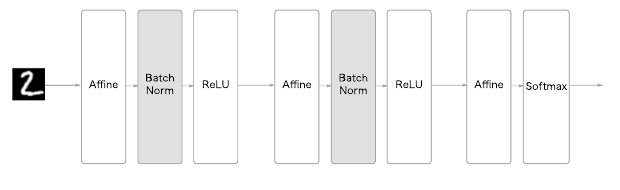

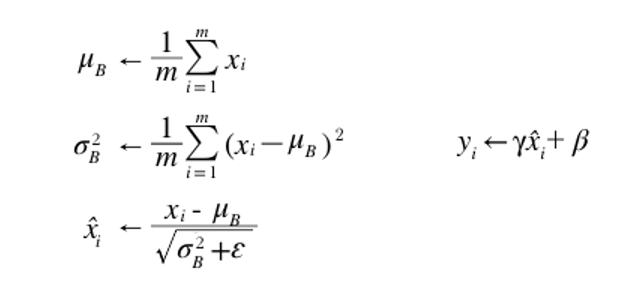

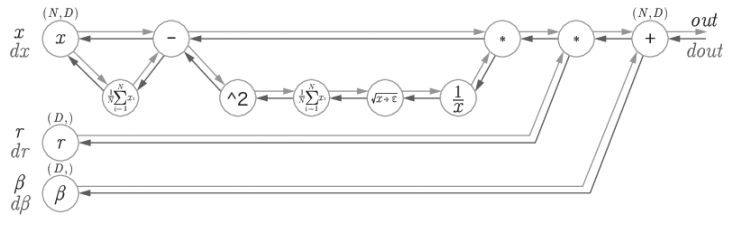

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from multi_layer_net_extend import MultiLayerNetExtend
from optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

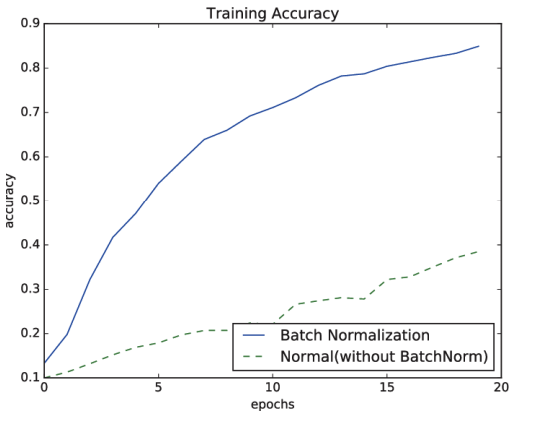

가중치 초깃값의 표준편차를 다양하게 바꿔가며 학습 경과를 관찰한 그래프

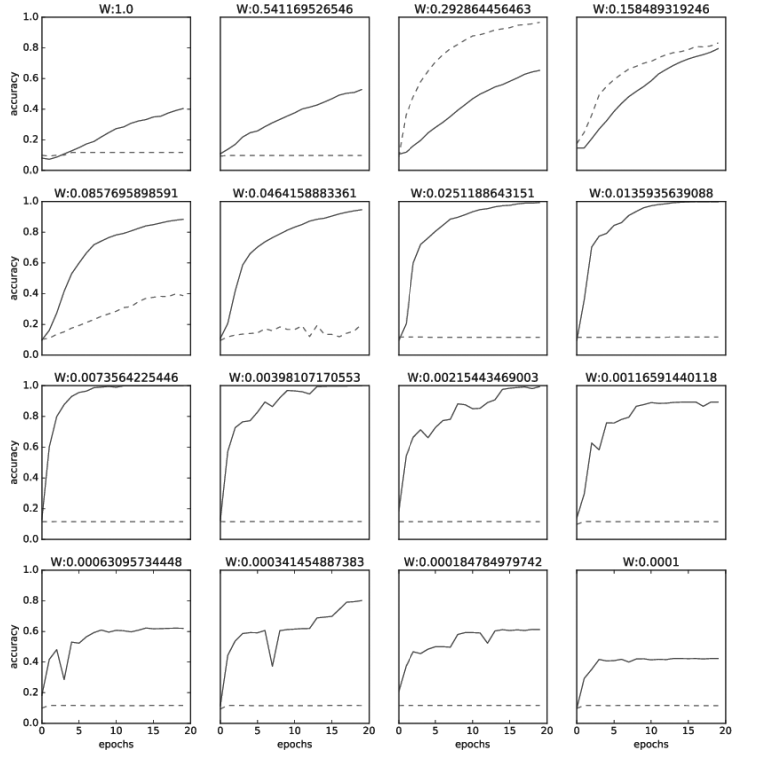

**오버피팅**
: 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태

1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음

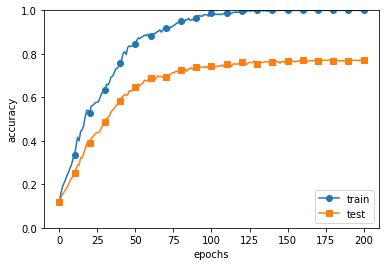

가중치 감소

학습과정에서 큰  가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법
- 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문

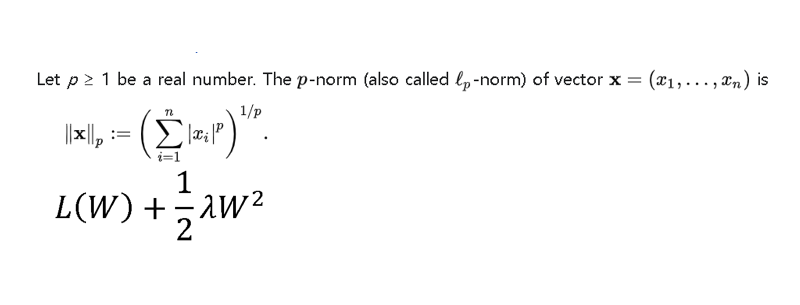

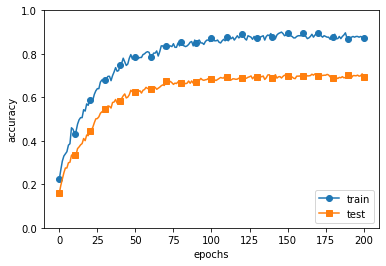

**드롭아웃(Dropout):**

드롭아웃은 뉴런을 임의로 삭제하며 학습하는 방법으로 훈련과정에서 은닉층의 뉴런을 무작위로 골라 삭제한다. 단, 시험 때는 모든 뉴런에 신호를 전달하고 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력한다.

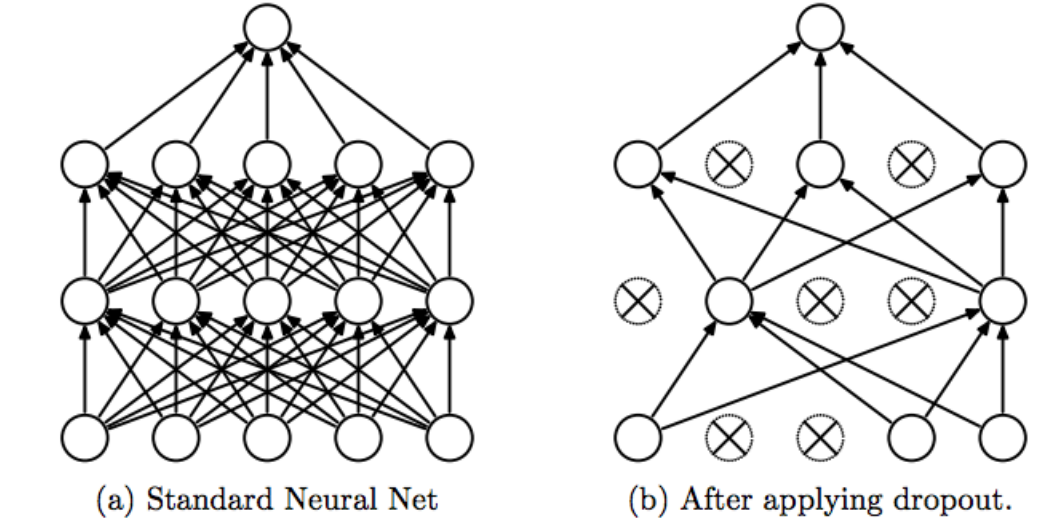

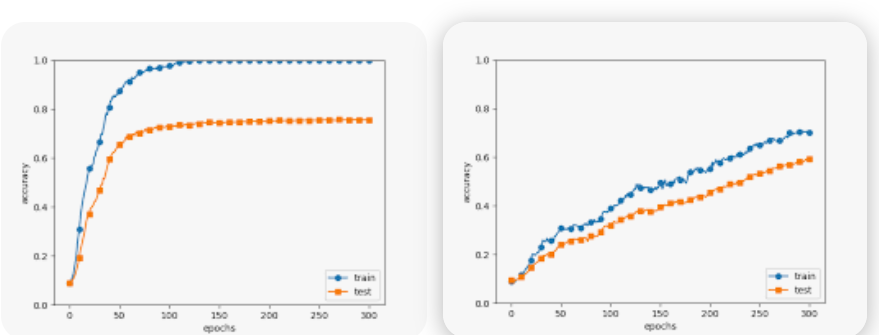

**하이퍼파라미터**

: 각 층의 뉴런수, 배치크기, 매개변수 갱신시의 학습률과 가중치 감소


검증 데이터

:하이퍼파라미터 전용 확인 데이터

(훈련 데이터: 매게변수 학습)
(검증 데이터: 하이퍼파라미터 성능 평가)
(시험 데이터: 신경망의 범용성능 평가)


하이퍼파라미터 최적화

0단계
하이퍼파라미터 값의 범위를 설정

1단계
설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출

2단계
1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가

3단계
1단계와 2단계를 특정(100회 등) 반복하며, 정확도를 보고 하이퍼파라미터의 범위를 좁힌다

cd. 베이즈 최적화